import urllib.request

url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
week_nums = [210109, 210116, 210123, 210130, 210206, 210213, 210220, 210227, 210306, 210313, 210320,
210327, 210403, 210410, 210417]

for week_num in week_nums:
    urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
                               f"data/turnstile_{week_num}.txt")

/Users/philliprichardson/Metis/Module 1/mta.db

In [15]:
from sqlalchemy import create_engine
import pandas as pd


engine = create_engine("sqlite:///mta.db")
all_data = pd.read_sql('with mta as(select *, row_number() over (PARTITION by CA, UNIT,  STATION,  SCP, date, time order by CA, UNIT,  STATION,  SCP, date, time) as dupes from mta_data) select *, case when (time between 11 and 12) then "Morning rush" when (time between 19 and 20) then "Evening rush" else "" end as rush_hour, LAG ( entries, 1, 0 ) OVER ( partition by CA, UNIT,  STATION,  SCP ORDER BY date, time)  as entered, LAG ( exits, 1, 0 ) OVER ( partition by CA, UNIT,  STATION,  SCP ORDER BY date, time) as exited from mta where dupes = 1;', engine)


In [16]:
# Converting the text date into an actual date value
all_data['DOW'] = pd.to_datetime(all_data['DATE'])

# Converting the new date value into a Day of Week format
all_data['DOW1'] = all_data['DOW'].dt.strftime('%a')
all_data['week_num'] = all_data['DOW'].dt.strftime('%V').astype(int)



In [17]:
all_data.head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,dupes,rush_hour,entered,exited,DOW,DOW1,week_num
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,03:00:00,REGULAR,7511653,2558871,1,,0,0,2021-01-02,Sat,53
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,07:00:00,REGULAR,7511655,2558877,1,,7511653,2558871,2021-01-02,Sat,53
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,11:00:00,REGULAR,7511677,2558930,1,Morning rush,7511655,2558877,2021-01-02,Sat,53
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,15:00:00,REGULAR,7511766,2558968,1,,7511677,2558930,2021-01-02,Sat,53
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,19:00:00,REGULAR,7511912,2558999,1,Evening rush,7511766,2558968,2021-01-02,Sat,53


What stations experience the most traffic during standard commute hours? (7-11) (15-19)

Question: We want to better allocate our employees during rush hour/standard commute hours, what stations represent the highest priority during the rush hour time frame? 

How are we measuring traffic? Is there a difference between exits and entrances? Does the # of lines impact traffic?

Do Covid Cases in NYC have a relationship (given 2 week lag) with ridership?

In [23]:
# Isolating weekdays and non-first measure hour slots (i.e. the first measurement we have for a given turnstile, 
# which would have no prior window to compare to)

all_data['Agg_enters'] = all_data['ENTRIES'] - all_data['entered']
all_data['Agg_exits'] = all_data['EXITS'] - all_data['exited']
all_data['traffic'] = all_data['Agg_enters'] + all_data['Agg_exits']

neg = (all_data['traffic'] < 0)

all_data.loc[neg, 'traffic'] = all_data.loc[neg, 'traffic'] * -1


#Avoid magic number (20)

mask = (all_data['entered'] != 0) & (all_data['DOW1'] != 'Sat') &  (all_data['DOW1'] != 'Sun') & (all_data['rush_hour'] != "") & (all_data['traffic'] < 40000) & (all_data['week_num'] != 53)



3126704        0
217322         0
217320         0
217316         0
217314         0
           ...  
1788312    11252
1282465    17256
1795918    17876
1929562    24888
1876531    35424
Name: traffic, Length: 270806, dtype: int64

## Aproach to Outliers

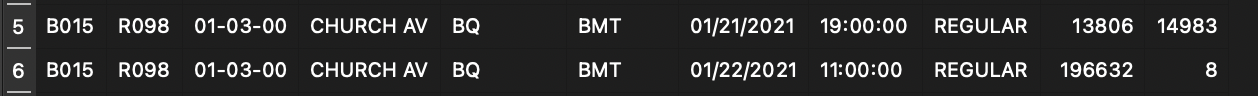

One of the reasons for outliers (based on 'Agg_enters' and 'Agg_exits' columns) is missing and faulty raw data. We are missing 3 records for the attached screenshot, and the 'Entries' and 'Exits' values don't make sense in the way that the cumulative numbers either jump drastically or fall drastically. 

I believe the best course of action, because this stems from the raw data, is to drop these rows with _extreme_ values (>20,000k agg_enter/exits). After checking ~100 rows of the data (random groups of 10) for validity in the 'Agg_enters' and 'Agg_exits' columns (manually comparing prior hour slot records, and doing the arithmetic by hand), it seems that the data not considered outliers are accurately calculated. 

Without filtering for these extreme outlier cases we have 270,849 records. After filtering for outliers (Aggregate enters/exits > 20,000) we get 270,838 records. 

In [32]:
station_daily = all_data[mask].groupby(['STATION', 'DOW', 'rush_hour', 'week_num', 'DOW1']).traffic.sum().reset_index()

station_daily['RH_Avg'] = station_daily.groupby(['DOW', 'week_num','DOW1', 'rush_hour']).traffic.transform(lambda x: x.mean())
station_daily['RH_std'] = station_daily.groupby(['DOW', 'week_num','DOW1', 'rush_hour']).traffic.transform(lambda x: x.std())

In [40]:
station_daily['traffic_normalized'] = (station_daily['traffic']-station_daily['RH_Avg'])/station_daily['RH_std']

In [41]:
station_daily.head()

,STATION,DOW,rush_hour,week_num,DOW1,traffic,RH_Avg,RH_std,traffic_normalized
0,1 AV,2021-01-04,Evening rush,1,Mon,4293,2427.947826,2957.992634,0.630513
1,1 AV,2021-01-04,Morning rush,1,Mon,3546,1947.891304,2245.268708,0.711767
2,1 AV,2021-01-05,Evening rush,1,Tue,4348,2474.140351,3017.327860,0.621033
3,1 AV,2021-01-05,Morning rush,1,Tue,3694,1986.381579,2273.388208,0.751134
4,1 AV,2021-01-06,Evening rush,1,Wed,4519,2502.774892,3034.853606,0.664357
